In [158]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ammar.jamalludin\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

from skimage.filters import threshold_local
from PIL import Image

<function matplotlib.pyplot.show(close=None, block=None)>

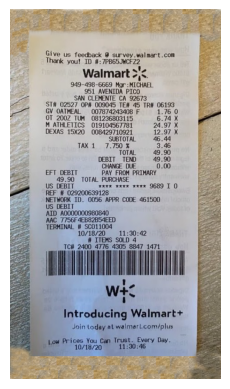

In [159]:
# Sample file out of the dataset
file_name = '../data/images/walmart_receipt_unprocessed.png'
img = Image.open(file_name)
img.thumbnail((800,800), Image.Resampling.LANCZOS)
plt.imshow(img)
plt.axis('off')
plt.show

In [180]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

def plot_rgb(image):
    plt.figure(figsize=(12,6))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

def plot_gray(image):
    plt.figure(figsize=(12,6))
    return plt.imshow(image, cmap='Greys_r')

In [161]:
image = cv2.imread(file_name)
#downscale image
resize_ratio = 1000 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

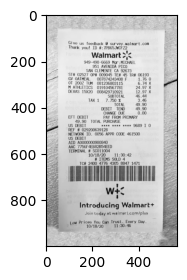

In [162]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

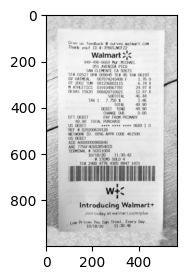

In [163]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

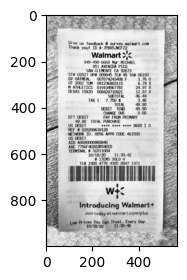

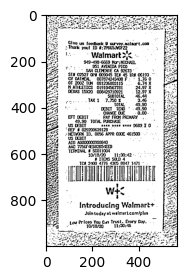

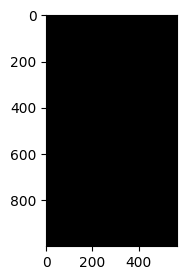

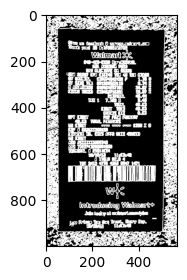

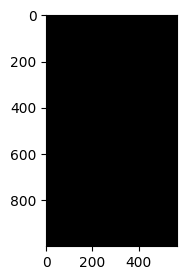

In [164]:
# Detect white regions and strengthen receipt edges
# 1) Contrast enhancement with CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(blurred)
plot_gray(enhanced)

# 2) Adaptive thresholding to capture white paper regions
thresh = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 15, 9)
plot_gray(thresh)

# 3) Morphological closing to fill small holes and unify the receipt body
close_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, close_kernel)
plot_gray(closed)

# 4) Edge detection on the contrast-enhanced image and dilate to thicken
edges = cv2.Canny(enhanced, 50, 150, apertureSize=3)
edges_dilated = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)), iterations=1)
plot_gray(edges_dilated)

# 5) Combine the edges with closed white regions to ensure receipt border is preserved
combined = cv2.bitwise_or(closed, edges_dilated)
plot_gray(combined)

# keep variable name for downstream steps
dilated = combined

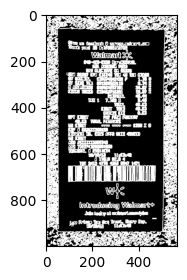

In [165]:
# Use Canny on the contrast-enhanced image, then combine with the mask edges
edged_enhanced = cv2.Canny(enhanced, 50, 150, apertureSize=3)
# combine with edges from the combined mask to preserve borders
edged = cv2.bitwise_or(edged_enhanced, edges_dilated)
plot_gray(edged)

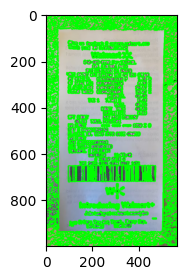

In [166]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

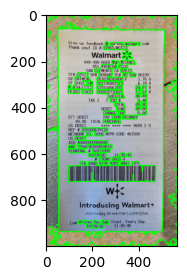

In [167]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [168]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    # Increased to 0.08 for aggressive simplification to get 4-sided largest contour
    return cv2.approxPolyDP(contour, 0.08 * peri, True)

In [169]:
def get_receipt_contour(contours):    
    # Try to find a contour with 4-6 sides (flexible rectangle detection)
    for c in contours:
        approx = approximate_contour(c)
        # Accept quadrilaterals and similar shapes (4-6 sides)
        if 4 <= len(approx) <= 6:
            return approx
    
    # Fallback: if no good candidate found, return the largest contour
    # (the first one, since they're sorted by area)
    if len(contours) > 0:
        return approximate_contour(contours[0])

In [170]:
get_receipt_contour(largest_contours)

array([[[ 88,  33]],

       [[511,  67]],

       [[478, 946]],

       [[ 47, 928]]], dtype=int32)

In [171]:
# Debug: Check which contours are 4-sided and their areas
for i, c in enumerate(largest_contours):
    approx = approximate_contour(c)
    area = cv2.contourArea(c)
    print(f"Contour {i}: {len(approx)} sides, area = {area:.0f}")
    if len(approx) == 4:
        print(f"  → This is a 4-sided contour (candidate for receipt)")

Contour 0: 2 sides, area = 550700
Contour 1: 4 sides, area = 398702
  → This is a 4-sided contour (candidate for receipt)
Contour 2: 2 sides, area = 39638
Contour 3: 2 sides, area = 16213
Contour 4: 3 sides, area = 6186
Contour 5: 2 sides, area = 5422
Contour 6: 2 sides, area = 4626
Contour 7: 2 sides, area = 3704
Contour 8: 3 sides, area = 2882
Contour 9: 2 sides, area = 2716


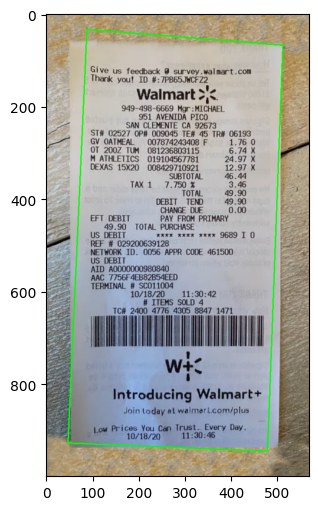

In [181]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0, 255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [173]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [174]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

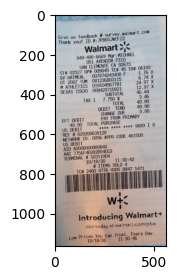

In [182]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(5,3))
plt.imshow(scanned)

In [183]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

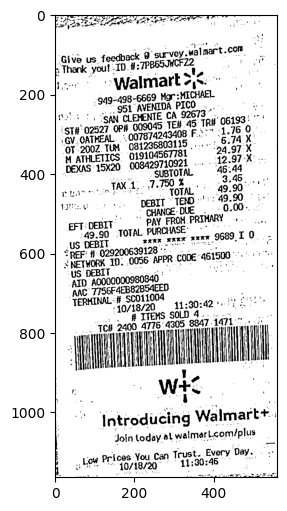

In [184]:
result = bw_scanner(scanned)
plot_gray(result)

In [185]:
output = Image.fromarray(result)
output.save('../data/images/resultSegment.png')

In [ ]:
# deprecated code, not going to be used, this ipynb is solely for image segmentation
# extracted_text = pytesseract.image_to_string('../data/images/resultSegment.png')
# print(" Extracted Text:\n")
# print(extracted_text)

 Extracted Text:

Peieeeline nea

Give us. feedback, @ survey: ‘walmart: con
3 Thank you! 1D a: =TPBESINCEZA “we

ter WMalmart 3,6.»
949-498-6669 Mor: MICHAEL
Peet AVENIDA PICO a
(1 SgAN CLEMENTE 673
*ST#' 02527 OPH 009045 tee 45° TR 06193: °
<GV-OATMEAL. » 007874243408 F- Fe vy 76 eo

“M ATHLETICS 019104567781 | 9a oa x
DEXAS "15X20 008429710921 ...- 12.97: X: -
SUBTOTAL

40

: 46.44
faa TOK. BB

aa TA top AL’ ¢ 49.90"
: aN TEND 2149.90, ©
CHANGE. DUE 0.00.
EFT: DEBIT ” PAY FROM PRIHARY 1
49. 30 TOTAL. PURCHA:
US DEBIT BREK pane tated 9689, Tt Oo .-
“REF: # 029200639128 = e
taney TD. .0056 APPR CODE 461500 viii

S DEBIT
AID '0000000980840..

AAC. TISGF4EBS2B54EED
TCH 2 i
in 1
Lo +

fons 1190242":
ml
” inst via

a nt ci ith

Low Prices wou Can Trust. Every Day.
10/18 420° 1:8 30: 48


